# BigData Final Project | Steam
## <font color = 'blue'> Notebook4 | Clustering </font>
### Team Member: Jim Fang, WooJong Choi, Han Jeon, Tam Nguyen

June 2020
___

## Cluster gamers based on their behavior: 

Using Kmeans to cluster gamers by their bahovior, using various features constructef from notebook 3 - Featuer engineering

Notebook Structure:
- Apply K-means model
- Visualize the cluster
- Basic decription about the cluster
- Top 10 most played games
- Game released year played by each cluster

---
## I. Import Libraries

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark.sql.types as t
from pyspark.sql.types import LongType
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, when, count, col, size
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import length
from pyspark.sql import functions as sf
from pyspark.sql.functions import collect_set, collect_list, array_contains
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.functions import rank, dense_rank
from pyspark.sql.functions import desc
from functools import reduce
from pyspark.sql.functions import rand 

#Sparkml, spark mllib
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.mllib.recommendation import ALS
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import mean, stddev, col
import numpy as np
import pandas as pd
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.enableHiveSupport().appName('Clustering').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '64g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','64g')])

sc = spark.sparkContext

In [3]:
!hdfs dfs -ls /user/tamng/jwht/EDA

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 12 items
drwxr-xr-x   - tamng tamng          0 2020-06-03 11:00 /user/tamng/jwht/EDA/friends.csv
drwxr-xr-x   - tamng tamng          0 2020-06-02 14:42 /user/tamng/jwht/EDA/merge_table.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 13:41 /user/tamng/jwht/EDA/player_app_cluster.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 12:14 /user/tamng/jwht/EDA/player_cluster.csv
drwxr-xr-x   - tamng tamng          0 2020-06-02 14:48 /user/tamng/jwht/EDA/player_df1.csv
drwxr-xr-x   - tamng tamng          0 2020-06-02 15:21 /user/tamng/jwht/EDA/player_df2.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 11:00 /user/tamng/jwht/EDA/player_df3.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 11:30 /user/tamng/jwht/EDA/player_df4.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 12:48 /user/tamng/jwht/EDA/player_df5.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 23:

---
## II. Create Function

_Quick check missing value_

In [4]:
def check_missing(df):
    ''' Check missing value'''
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

_Basic description of data_

In [5]:
def basic_info(df):    
    '''
        Print out the basic ddescription for each table, icluding:
        1. total rows/ observation
        2. Check missing value by columns
        3. Print out the first 3 lines
        4. Basic description
    '''   
    print('TOTAL ROWS:', df.count())
    print('\n')
    print('*-------------'*5)
    print('\n')
    print('MISSING VALUE:')
    check_missing(df)
    print('*-------------'*5)
    print('\n')
    print('PRINT OUT THE 1st 3 LINES:')
    df.show(3, truncate = True)
    print('*-------------'*5)
    print('\n')
    print('TABLE BASIC DESCRIPTION:')
    df.describe().show(10,truncate = True)
    print('*-------------'*5)
    distinct_count = []
    column_name = df.columns
    for i in column_name:
        distinct_count.append(df.select(col(i)).distinct().count())

    print('DISTINCT COUNT BY COLUMN:')
    print('\n')
    print(pd.DataFrame(zip(column_name,distinct_count)).\
      rename(columns={0:'column_name', 1:'distinct_count'}))

_Rename columns based on predefined list_

In [6]:
def rename_col(df, newColumns):
    ''' Rename all columns        
        Note: newColumns is a list of columns name '''
    oldColumns = df.schema.names
    df = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)
    return df

_Plot distribution of year released by cluster_

In [ ]:
def count_plot_year(df):
    '''
        Plot distribution by year for each cluster
        df: dataframe
    '''
    plt.figure(figsize = (20, 8))
    sns.barplot(x =df['year'], y=df['movies_by_releasedyear'])

---
## III. Import Data

In [60]:
player_final = spark.read.csv('/user/tamng/jwht/EDA/player_final.csv', inferSchema = True, header = True)

In [61]:
player_final.count()

3125641

In [8]:
player_final.columns

['steam_id',
 'total_playtime_2weeks',
 'total_playtime_forever',
 'total_games_owned',
 'total_money_spend',
 'total_game_multi_player',
 'total_game_single_player',
 'gr_education_total',
 'gr_mutiplayer_total',
 'gr_adventure_total',
 'gr_sports_total',
 'gr_accounting_total',
 'gr_audioProduction_total',
 'gr_videoProduction_total',
 'gr_animationModeling_total',
 'gr_racing_total',
 'gr_designIllustration_total',
 'gr_softwareTraining_total',
 'gr_photoEditing_total',
 'gr_webPublishing_total',
 'gr_utility_total',
 'gr_earlyAccess_total',
 'gr_casual_total',
 'gr_action_total',
 'gr_strategy_total',
 'gr_indie_total',
 'gr_freeplay_total',
 'gr_RPG_total',
 'gr_simulation_total',
 'number_friends',
 'number_groups',
 'year_active',
 'year_inactive',
 'year_created',
 'country_code',
 'total_games_not_played',
 'total_games_played']

In [9]:
player_final.limit(5).toPandas()

,steam_id,total_playtime_2weeks,total_playtime_forever,total_games_owned,total_money_spend,total_game_multi_player,total_game_single_player,gr_education_total,gr_mutiplayer_total,gr_adventure_total,...,gr_RPG_total,gr_simulation_total,number_friends,number_groups,year_active,year_inactive,year_created,country_code,total_games_not_played,total_games_played
0,76561197960269356,0,5694,15,99.88,12,3,0.0,0.0,0.0,...,0.0,0.0,5,0,10.0,1.0,2003,US,9,6
1,76561197960270928,536,155518,56,785.53,43,13,0.0,4.0,8.0,...,4.0,8.0,32,3,11.0,0.0,2003,SE,16,40
2,76561197960271038,0,2567,73,935.28,32,41,0.0,0.0,19.0,...,14.0,3.0,16,2,11.0,0.0,2003,CA,67,6
3,76561197960271906,0,194676,138,1936.73,78,60,0.0,3.0,28.0,...,19.0,15.0,76,11,11.0,0.0,2003,US,66,72
4,76561197960271972,0,73281,32,465.71,22,10,0.0,1.0,1.0,...,4.0,0.0,16,0,11.0,0.0,2003,N,15,17


---
## IV. Clustering


### 1. Select features that are relevant for clustering

In [10]:
cols = ['steam_id',
     'total_playtime_forever',
     'total_games_owned',
     'total_money_spend',
     'total_game_single_player',
     'gr_mutiplayer_total',
     'gr_adventure_total',
     'gr_sports_total',
     'gr_racing_total',
     'gr_earlyAccess_total',
     'gr_casual_total',
     'gr_action_total',
     'gr_strategy_total',
     'gr_indie_total',
     'gr_freeplay_total',
     'gr_RPG_total',
     'gr_simulation_total',
     'number_friends',
     'number_groups',
     'year_active',
     'year_inactive',
     'total_games_not_played']

In [11]:
df1 = player_final.select(cols)

In [12]:
feature_col = df1.columns[1::]

### 2. Convert datetype to float (KMeans - Readable format)

In [13]:
for col in df1.columns:
    if col in feature_col:
        df1 = df1.withColumn(col,df1[col].cast('float'))

### 3. Vector Assemble

In [14]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features", handleInvalid="keep")
df_kmeans = vecAssembler.transform(df1).select("steam_id", "features")

### 4. Scale data

In [15]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

In [16]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_kmeans)

# Normalize each feature to have unit standard deviation.
df_kmeans = scalerModel.transform(df_kmeans)

### 5. K.Means - select optimal k value
>  Based on the graph, 6 should be the optimal number of clusters

In [18]:
%%time
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features").setPredictionCol("cluster")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=911))
    cost[k] = model.computeCost(df_kmeans)

CPU times: user 118 ms, sys: 42.1 ms, total: 160 ms
Wall time: 1min 11s


Text(0,0.5,'cost')

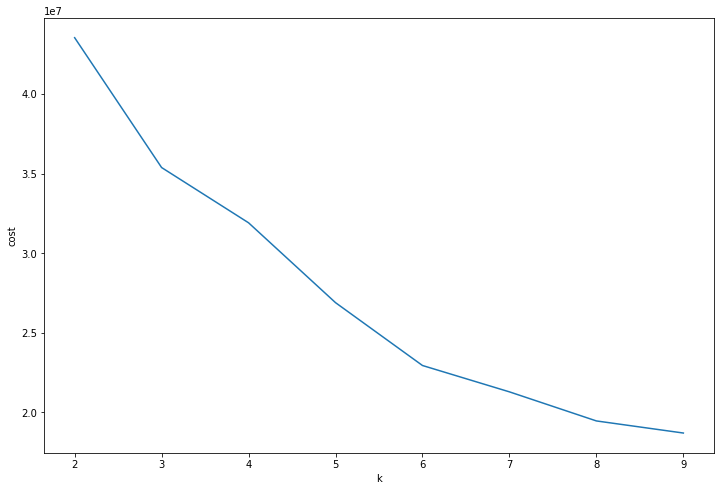

In [19]:
fig, ax = plt.subplots(1,1, figsize =(12,8))
ax.plot(range(2,10),cost[2:15])
ax.set_xlabel('k')
ax.set_ylabel('cost')

### 6. Run prediction cluster

In [20]:
# Fit model with chosen value of k
k = 6
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [22]:
# trandform 
transformed = model.transform(df_kmeans).select("steam_id", "prediction")
rows = transformed.collect()

# get the prediction data : steam_id + prediction cluter
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-----------------+----------+
|         steam_id|prediction|
+-----------------+----------+
|76561197960269356|         1|
|76561197960270928|         2|
|76561197960271038|         1|
|76561197960271906|         2|
|76561197960271972|         1|
|76561197960272055|         1|
|76561197960272209|         2|
|76561197960272461|         1|
|76561197960272486|         1|
|76561197960272509|         3|
|76561197960272641|         4|
|76561197960272695|         1|
|76561197960272933|         1|
|76561197960273067|         1|
|76561197960273217|         2|
|76561197960273281|         1|
|76561197960273447|         1|
|76561197960273557|         2|
|76561197960275336|         1|
|76561197960275683|         4|
+-----------------+----------+
only showing top 20 rows



In [24]:
df_pred = df_pred.withColumnRenamed("prediction", "cluster")
df_pred.groupby('cluster').count().orderBy('count',ascending = False).show()

+-------+-------+
|cluster|  count|
+-------+-------+
|      1|1500398|
|      4|1295494|
|      2| 203399|
|      3|  90692|
|      0|  34361|
|      5|   1297|
+-------+-------+



### 7. Visualize the results

In [27]:
df_kmeans.limit(2).toPandas()

,steam_id,features,scaled_features
0,76561197960269356,"(5694.0, 15.0, 99.87999725341797, 3.0, 0.0, 0....","(0.1141997955917086, 0.2632524894743982, 0.130..."
1,76561197960270928,"[155518.0, 56.0, 785.530029296875, 13.0, 4.0, ...","[3.1190944522007973, 0.9828092940377534, 1.024..."


In [26]:
# Reverse VectorAssembler features
split_df = df_kmeans.select('scaled_features').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [28]:
split_df.limit(2).toPandas()

,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,...,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21
0,0.114200,0.263252,0.130209,0.084698,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.228833,0.000000,3.799907,0.394159,0.266712
1,3.119094,0.982809,1.024062,0.367024,3.664836,0.54206,2.744838,1.986218,2.084097,0.0,...,0.617097,0.592062,3.795531,0.354076,1.448215,1.464531,0.437618,4.179898,0.000000,0.474155


In [29]:
# rename split_df
split_df = rename_col(split_df, cols[1::])
split_df.limit(2).toPandas()

,total_playtime_forever,total_games_owned,total_money_spend,total_game_single_player,gr_mutiplayer_total,gr_adventure_total,gr_sports_total,gr_racing_total,gr_earlyAccess_total,gr_casual_total,...,gr_strategy_total,gr_indie_total,gr_freeplay_total,gr_RPG_total,gr_simulation_total,number_friends,number_groups,year_active,year_inactive,total_games_not_played
0,0.114200,0.263252,0.130209,0.084698,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.228833,0.000000,3.799907,0.394159,0.266712
1,3.119094,0.982809,1.024062,0.367024,3.664836,0.54206,2.744838,1.986218,2.084097,0.0,...,0.617097,0.592062,3.795531,0.354076,1.448215,1.464531,0.437618,4.179898,0.000000,0.474155


In [30]:
steam_id_df = df_kmeans.select('steam_id')

In [31]:
# since there is no common column between these two dataframes add row_index so that it can be joined
steam_id_df=steam_id_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
split_df=split_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

steam_id_df = steam_id_df.join(split_df, on=["row_index"]).drop("row_index")

In [32]:
steam_id_df.limit(2).toPandas()

,steam_id,total_playtime_forever,total_games_owned,total_money_spend,total_game_single_player,gr_mutiplayer_total,gr_adventure_total,gr_sports_total,gr_racing_total,gr_earlyAccess_total,...,gr_strategy_total,gr_indie_total,gr_freeplay_total,gr_RPG_total,gr_simulation_total,number_friends,number_groups,year_active,year_inactive,total_games_not_played
0,76561197960269356,0.114200,0.263252,0.130209,0.084698,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.228833,0.000000,3.799907,0.394159,0.266712
1,76561197960270928,3.119094,0.982809,1.024062,0.367024,3.664836,0.54206,2.744838,1.986218,2.084097,...,0.617097,0.592062,3.795531,0.354076,1.448215,1.464531,0.437618,4.179898,0.000000,0.474155


In [33]:
df_pred_join = df_pred.join(steam_id_df, 'steam_id')

In [41]:
cluster_pred = df_pred_join.limit(1000000).toPandas().set_index('steam_id')
cluster_pred.head(2)

,cluster,total_playtime_forever,total_games_owned,total_money_spend,total_game_single_player,gr_mutiplayer_total,gr_adventure_total,gr_sports_total,gr_racing_total,gr_earlyAccess_total,...,gr_strategy_total,gr_indie_total,gr_freeplay_total,gr_RPG_total,gr_simulation_total,number_friends,number_groups,year_active,year_inactive,total_games_not_played
steam_id,,,,,,,,,,,,,,,,,,,,,
76561197960266870,3,0.000120,0.140401,0.065079,0.028233,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.091533,0.000000,2.279944,1.970797,0.207443
76561197960266911,0,0.065503,0.263252,0.156256,0.112931,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.457666,0.291745,3.799907,0.394159,0.355616


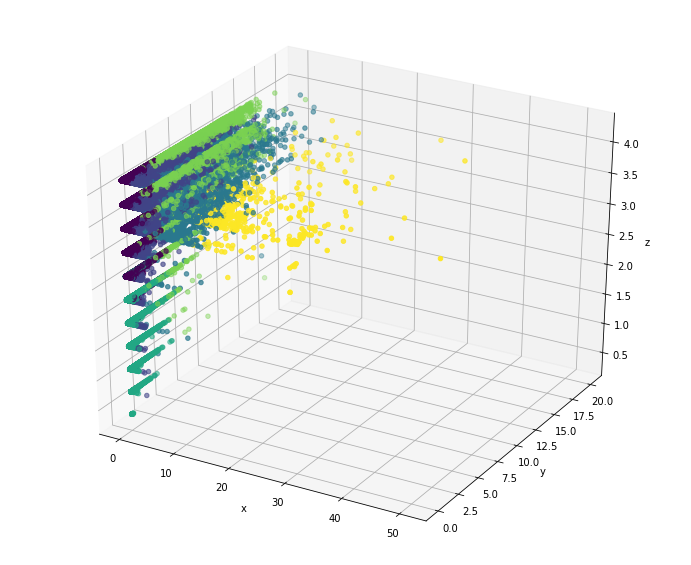

In [42]:
cluster_plot = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_plot.scatter(cluster_pred.total_money_spend, \
                     cluster_pred.number_friends, cluster_pred.year_active, c=cluster_pred.cluster)
cluster_plot.set_xlabel('x')
cluster_plot.set_ylabel('y')
cluster_plot.set_zlabel('z')
plt.show()

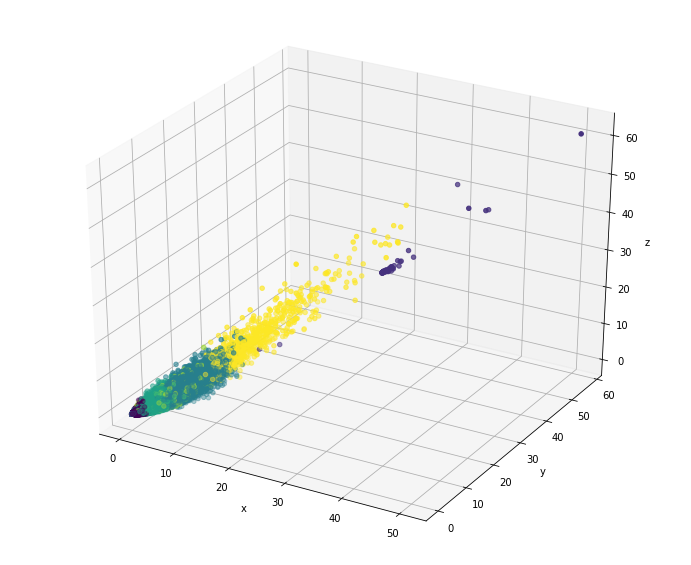

In [125]:
cluster_plot = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_plot.scatter(cluster_pred.total_money_spend, \
                     cluster_pred.total_games_owned, cluster_pred.gr_adventure_total, c=cluster_pred.cluster)
cluster_plot.set_xlabel('x')
cluster_plot.set_ylabel('y')
cluster_plot.set_zlabel('z')
plt.show()

### 8. Add cluster number to data needed to draw the profile of each cluster

---
#### a. `player_app_cluster` : merge_table + cluster

In [54]:
# Load merge_table
merge_table = spark.read.csv('/user/tamng/jwht/EDA/merge_table.csv',inferSchema = True, header = True)

In [55]:
merge_table.count()

93598775

In [58]:
# add cluster to merge table
player_app_cluster = merge_table.join(df_pred,'steam_id')

In [59]:
player_app_cluster.count()

82975759

In [65]:
# Get the released year
player_app_cluster = player_app_cluster.withColumn('year', \
                                                   F.split('releaseDate', '/').getItem(2)).withColumn('year', F.split('year', ' ').getItem(0))

In [66]:
player_app_cluster.limit(2).toPandas()

,steam_id,app_id,playtime_2weeks,playtime_forever,dateretrieved,title,type,price,releaseDate,rating,...,Early Access,Casual,Action,Strategy,Indie,Free to Play,RPG,Simulation,cluster,year
0,76561197960266870,10,0,6,2014-08-14 14:04:58,Counter-Strike,game,9.99,11/1/2000 0:00,88,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,2000
1,76561197960266870,20,0,0,2014-08-14 14:04:58,Team Fortress Classic,game,4.99,4/1/1999 0:00,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,1999


In [17]:
# Save data
player_app_cluster.write.csv('/user/tamng/jwht/EDA/player_app_cluster.csv', header = True)

---
## V.  Cluster profiling

### 1. Cluster size

In [36]:
cluster = df_pred.groupby('cluster').count().orderBy('count',ascending = False).toPandas()
cluster

,cluster,count
0,1,1500398
1,4,1295494
2,2,203399
3,3,90692
4,0,34361
5,5,1297


In [37]:
cluster_order = cluster.cluster.tolist()

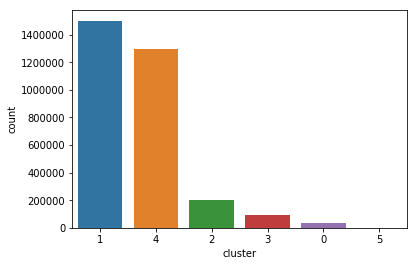

In [38]:
sns.barplot(x='cluster', y='count', data = cluster, order = cluster_order)

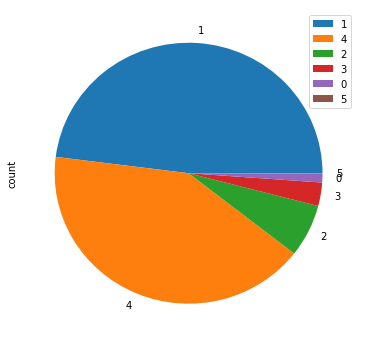

In [60]:
cluster.plot.pie(y='count', labels = cluster['cluster'], figsize=(6, 6))

In [40]:
df_pred.count()

3125641

In [41]:
# Save player_cluster: steam_id + cluster
df_pred.write.csv('/user/tamng/jwht/EDA/player_cluster.csv', header = True)

In [56]:
# Load data
df_pred= spark.read.csv('/user/tamng/jwht/EDA/player_cluster.csv', inferSchema = True, header = True)

In [57]:
df_pred.count()

3125641

---

### 2. Top 20 games by clusters

> Need to look at game name alone does not help, need to look at lease year version also

_1. Cluster 0_

In [28]:
top20games_cluster0 = player_app_cluster.filter(F.col('cluster')==0).groupBy('app_id', 'title', 'year').count().orderBy('count', ascending = False).limit(20)
top20games_cluster0.toPandas()

,app_id,title,year,count
0,340,Half-Life 2: Lost Coast,2005,33782
1,220,Half-Life 2,2004,33679
2,240,Counter-Strike: Source,2004,32846
3,320,Half-Life 2: Deathmatch,2004,32747
4,400,Portal,2007,32453
5,550,Left 4 Dead 2,2009,32219
6,620,Portal 2,2011,31145
7,43110,Metro 2033,2010,30805
8,42910,Magicka,2011,30231
9,55230,Saints Row: The Third,2011,30206


_2. Cluster 1_

In [29]:
top20games_cluster1 = player_app_cluster.filter(F.col('cluster')==1).groupBy('app_id', 'title', 'year').count().orderBy('count', ascending = False).limit(20)
top20games_cluster1.toPandas()

,app_id,title,year,count
0,240,Counter-Strike: Source,2004,1087783
1,340,Half-Life 2: Lost Coast,2005,1077927
2,10,Counter-Strike,2000,1072578
3,320,Half-Life 2: Deathmatch,2004,1059391
4,220,Half-Life 2,2004,1021360
5,70,Half-Life,1998,938024
6,50,Half-Life: Opposing Force,1999,930025
7,30,Day of Defeat,2003,929967
8,130,Half-Life: Blue Shift,2001,929950
9,20,Team Fortress Classic,1999,929927


_3. Cluster 2_

In [31]:
top20games_cluster2 = player_app_cluster.filter(F.col('cluster')==4).groupBy('app_id', 'title','year').count().orderBy('count', ascending = False).limit(20)
top20games_cluster2.toPandas()

,app_id,title,year,count
0,10,Counter-Strike,2000,913167
1,30,Day of Defeat,2003,743583
2,40,Deathmatch Classic,2001,742533
3,60,Ricochet,2000,742526
4,70,Half-Life,1998,741155
5,20,Team Fortress Classic,1999,740162
6,50,Half-Life: Opposing Force,1999,739515
7,130,Half-Life: Blue Shift,2001,739500
8,240,Counter-Strike: Source,2004,672931
9,340,Half-Life 2: Lost Coast,2005,670399


_4. Cluster 3_

In [32]:
top20games_cluster3 = player_app_cluster.filter(F.col('cluster')==2).groupBy('app_id', 'title', 'year').count().orderBy('count', ascending = False).limit(20)
top20games_cluster3.toPandas()

,app_id,title,year,count
0,340,Half-Life 2: Lost Coast,2005,193459
1,220,Half-Life 2,2004,191059
2,240,Counter-Strike: Source,2004,189288
3,320,Half-Life 2: Deathmatch,2004,186592
4,550,Left 4 Dead 2,2009,163981
5,400,Portal,2007,163827
6,440,Team Fortress 2,2007,153050
7,210770,Sanctum 2,2013,144929
8,10,Counter-Strike,2000,142312
9,620,Portal 2,2011,141802


_5. Cluster 4_

In [33]:
top20games_cluster4 = player_app_cluster.filter(F.col('cluster')==3).groupBy('app_id', 'title','year').count().orderBy('count', ascending = False).limit(20)
top20games_cluster4.toPandas()

,app_id,title,year,count
0,10,Counter-Strike,2000,75662
1,240,Counter-Strike: Source,2004,72344
2,340,Half-Life 2: Lost Coast,2005,70068
3,320,Half-Life 2: Deathmatch,2004,68004
4,70,Half-Life,1998,64915
5,220,Half-Life 2,2004,64235
6,30,Day of Defeat,2003,64224
7,20,Team Fortress Classic,1999,63834
8,50,Half-Life: Opposing Force,1999,63817
9,130,Half-Life: Blue Shift,2001,63754


_6. Cluster 5_

In [34]:
top20games_cluster5 = player_app_cluster.filter(F.col('cluster')==5).groupBy('app_id', 'title','year').count().orderBy('count', ascending = False).limit(20)
top20games_cluster5.toPandas()

,app_id,title,year,count
0,42910,Magicka,2011,1294
1,340,Half-Life 2: Lost Coast,2005,1292
2,220,Half-Life 2,2004,1290
3,43110,Metro 2033,2010,1287
4,550,Left 4 Dead 2,2009,1284
5,35720,Trine 2: Complete Story,2013,1284
6,55230,Saints Row: The Third,2011,1280
7,35700,Trine Enchanted Edition,2009,1276
8,400,Portal,2007,1275
9,210770,Sanctum 2,2013,1275


In [35]:
# Save data for future analysis
top20games_cluster0.write.csv('/user/tamng/jwht/Cluster/top20games_cluster0.csv', header = True)
top20games_cluster1.write.csv('/user/tamng/jwht/Cluster/top20games_cluster1.csv', header = True)
top20games_cluster2.write.csv('/user/tamng/jwht/Cluster/top20games_cluster2.csv', header = True)
top20games_cluster3.write.csv('/user/tamng/jwht/Cluster/top20games_cluster3.csv', header = True)
top20games_cluster4.write.csv('/user/tamng/jwht/Cluster/top20games_cluster4.csv', header = True)
top20games_cluster5.write.csv('/user/tamng/jwht/Cluster/top20games_cluster5.csv', header = True)

---
#### `player_final_cluster`: Add cluster to player_final

In [36]:
player_final_cluster = player_final.join(df_pred, 'steam_id')

In [37]:
player_final_cluster.limit(2).toPandas()

,steam_id,total_playtime_2weeks,total_playtime_forever,total_games_owned,total_money_spend,total_game_multi_player,total_game_single_player,gr_education_total,gr_mutiplayer_total,gr_adventure_total,...,gr_simulation_total,number_friends,number_groups,year_active,year_inactive,year_created,country_code,total_games_not_played,total_games_played,cluster
0,76561197960266870,0,6,8,49.92,7,1,0.0,0.0,0.0,...,0.0,2,0,6.0,5.0,2003,N,7,1,4
1,76561197960266911,0,3266,15,119.86,11,4,0.0,0.0,0.0,...,0.0,10,2,10.0,1.0,2003,DE,12,3,1


In [38]:
player_final_cluster.columns

['steam_id',
 'total_playtime_2weeks',
 'total_playtime_forever',
 'total_games_owned',
 'total_money_spend',
 'total_game_multi_player',
 'total_game_single_player',
 'gr_education_total',
 'gr_mutiplayer_total',
 'gr_adventure_total',
 'gr_sports_total',
 'gr_accounting_total',
 'gr_audioProduction_total',
 'gr_videoProduction_total',
 'gr_animationModeling_total',
 'gr_racing_total',
 'gr_designIllustration_total',
 'gr_softwareTraining_total',
 'gr_photoEditing_total',
 'gr_webPublishing_total',
 'gr_utility_total',
 'gr_earlyAccess_total',
 'gr_casual_total',
 'gr_action_total',
 'gr_strategy_total',
 'gr_indie_total',
 'gr_freeplay_total',
 'gr_RPG_total',
 'gr_simulation_total',
 'number_friends',
 'number_groups',
 'year_active',
 'year_inactive',
 'year_created',
 'country_code',
 'total_games_not_played',
 'total_games_played',
 'cluster']

In [39]:
# Aggregate the data to have a basic decription about the cluster
cluster_info = player_final_cluster.groupby('cluster').agg(F.count('*').alias('population'),
                                           (F.avg('total_money_spend')).alias('avg_money_spend'),
                                           (F.avg('total_games_owned')).alias('avg_games_owned'),
                                           (F.avg('total_games_played')).alias('avg_games_played'),
                                           (F.avg('total_games_not_played')).alias('avg_games_not_played'),
                                           (F.avg('total_playtime_forever')).alias('avg_playtime_forever'),
                                           (F.avg('total_game_multi_player')).alias('avg_game_multi_player'),
                                           (F.avg('total_game_single_player')).alias('avg_game_single_player'),
                                           (F.avg('number_friends')).alias('avg_number_friends'),
                                           (F.avg('number_groups')).alias('avg_number_groups'),
                                           (F.avg('year_active')).alias('avg_year_active'),
                                           (F.avg('year_inactive')).alias('avg_year_inactive'),
                                           (F.avg('gr_mutiplayer_total')).alias('avg_gr_mutiplayer'),
                                           (F.avg('gr_sports_total')).alias('avg_gr_sports'),
                                           (F.avg('gr_racing_total')).alias('avg_gr_racing'),
                                           (F.avg('gr_earlyAccess_total')).alias('avg_gr_earlyAccess'),
                                           (F.avg('gr_casual_total')).alias('avg_gr_casual'),
                                           (F.avg('gr_action_total')).alias('avg_gr_action'),
                                           (F.avg('gr_strategy_total')).alias('avg_gr_strategy'),
                                           (F.avg('gr_indie_total')).alias('avg_gr_indie'),
                                           (F.avg('gr_freeplay_total')).alias('avg_gr_freeplay'),
                                           (F.avg('gr_RPG_total')).alias('avg_gr_RPG'),
                                           (F.avg('gr_simulation_total')).alias('avg_gr_simulation'))

### 3. Cluster Profile_Summary

In [40]:
cluster_info.toPandas()

,cluster,population,avg_money_spend,avg_games_owned,avg_games_played,avg_games_not_played,avg_playtime_forever,avg_game_multi_player,avg_game_single_player,avg_number_friends,...,avg_gr_sports,avg_gr_racing,avg_gr_earlyAccess,avg_gr_casual,avg_gr_action,avg_gr_strategy,avg_gr_indie,avg_gr_freeplay,avg_gr_RPG,avg_gr_simulation
0,1,1500398,233.923223,19.562534,9.391770,10.170764,20704.030146,12.797255,6.765279,8.011954,...,0.089258,0.221293,0.122407,0.362896,16.691353,2.243929,2.021901,0.749976,1.629818,0.706124
1,3,90692,469.438145,36.414425,21.993781,14.420643,137368.940116,24.006472,12.407952,92.136539,...,0.328452,0.503815,0.449169,1.095786,30.026838,5.322068,5.862998,2.371665,4.017157,1.783652
2,5,1297,14414.286893,1249.910563,334.710871,915.199692,158175.397070,407.670008,842.240555,52.906708,...,26.981496,51.995374,14.367772,213.609098,615.077101,305.872783,549.814958,20.443331,220.354665,124.697764
3,4,1295494,59.931365,7.911993,1.053591,6.858402,772.690875,6.032909,1.879085,1.955395,...,0.001741,0.009331,0.003357,0.008022,7.843009,0.051009,0.060724,0.033556,0.041014,0.023650
4,2,203399,1818.710102,127.803323,74.692880,53.110443,95927.796302,61.020585,66.782737,22.519123,...,1.389284,2.243571,1.803799,8.452524,83.937399,28.739566,35.153988,4.470150,23.867389,10.157759
5,0,34361,4795.276796,362.490411,172.441955,190.048456,130989.461221,140.817206,221.673205,37.207648,...,5.289747,8.931638,3.740782,40.012456,208.275603,87.792177,134.279619,7.667676,68.386077,30.300952


In [41]:
cluster_info.write.csv('/user/tamng/jwht/Cluster/cluster_info.csv', header = True)

---
### 4. Distribution of game released year by cluster

_First, look at game they play by year_

In [108]:
# Save data as Pandas for plotting
year_game_cluster0 = als_df.filter(F.col('cluster')==0).groupby('year').count().orderBy('year').toPandas()
year_game_cluster1 = als_df.filter(F.col('cluster')==1).groupby('year').count().orderBy('year').toPandas()
year_game_cluster2 = als_df.filter(F.col('cluster')==2).groupby('year').count().orderBy('year').toPandas()
year_game_cluster3 =  als_df.filter(F.col('cluster')==3).groupby('year').count().orderBy('year').toPandas()
year_game_cluster4 =  als_df.filter(F.col('cluster')==4).groupby('year').count().orderBy('year').toPandas()
year_game_cluster5 =  als_df.filter(F.col('cluster')==5).groupby('year').count().orderBy('year').toPandas()

In [147]:
# Change year to string type
def rename_col(df):
    df.rename(columns={'count':'movies_by_releasedyear'}, inplace = True)

In [ ]:
# Rename column
rename_col(year_game_cluster0)
rename_col(year_game_cluster1)
rename_col(year_game_cluster2)
rename_col(year_game_cluster3)
rename_col(year_game_cluster4)
rename_col(year_game_cluster5)

In [150]:
year_game_cluster0

,year,movies_by_releasedyear
0,1970,78958
1,1997,230
2,1998,9943
3,1999,6781
4,2000,11964
5,2001,7062
6,2003,3366
7,2004,65040
8,2005,18772
9,2006,124885


In [151]:
def count_plot_year(df):
    '''
        Plot distribution by year for each cluster
        df: dataframe
    '''
    plt.figure(figsize = (20, 8))
    sns.barplot(x =df['year'], y=df['movies_by_releasedyear'])

__Cluster 0__

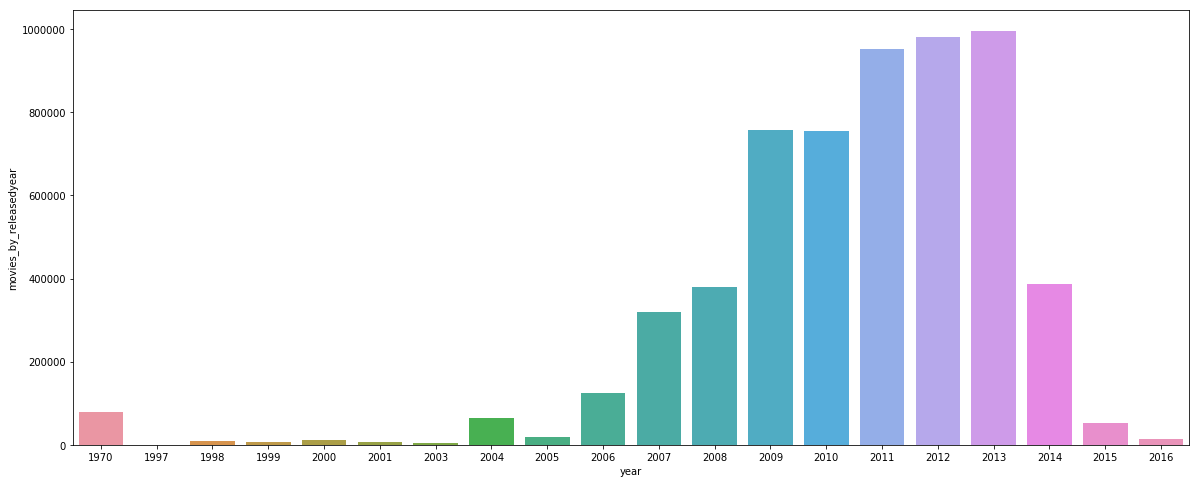

In [152]:
count_plot_year(year_game_cluster0)

__Cluster 1__

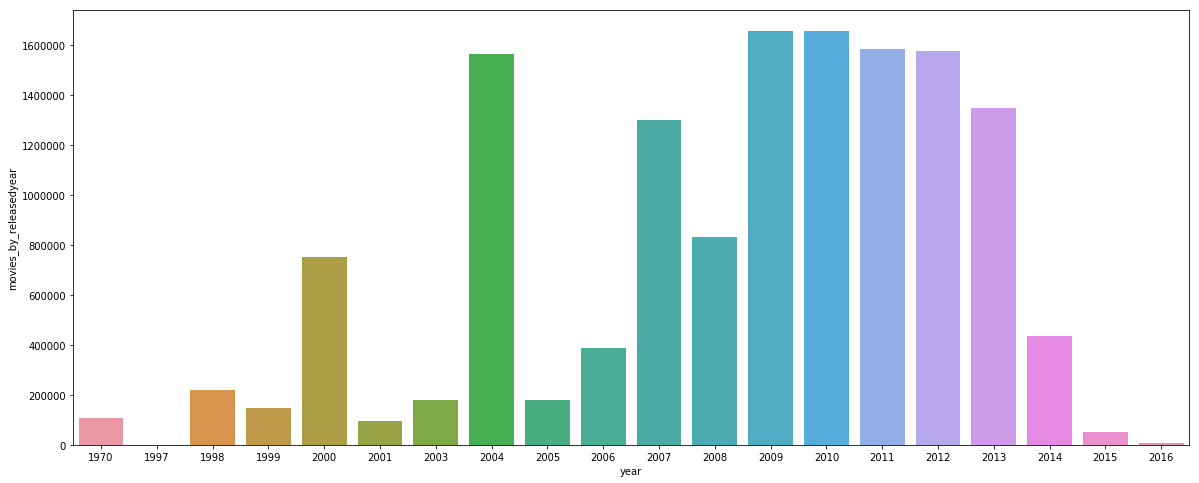

In [153]:
count_plot_year(year_game_cluster1)

__Cluster 2__

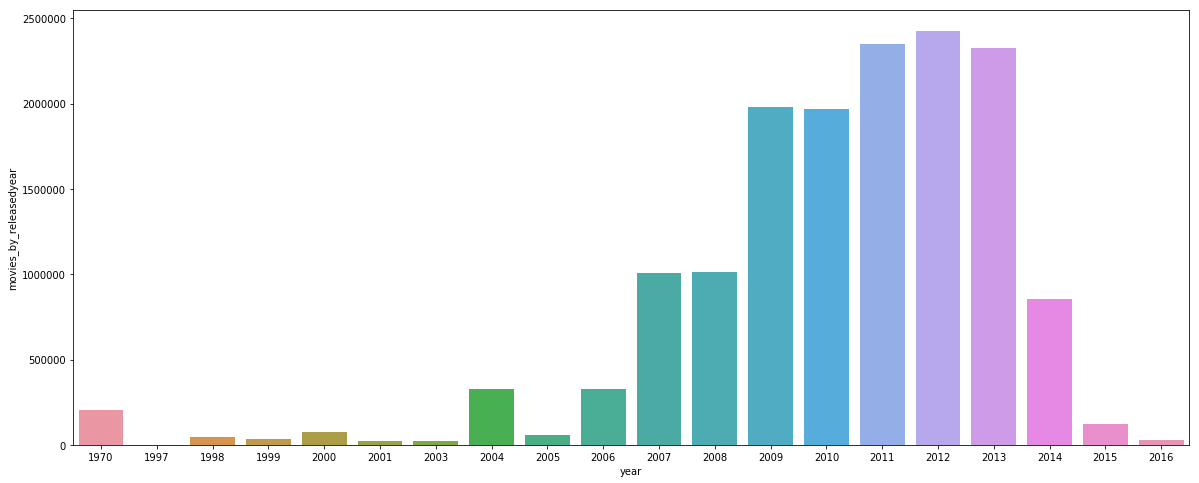

In [154]:
count_plot_year(year_game_cluster2)

__Cluster 3__

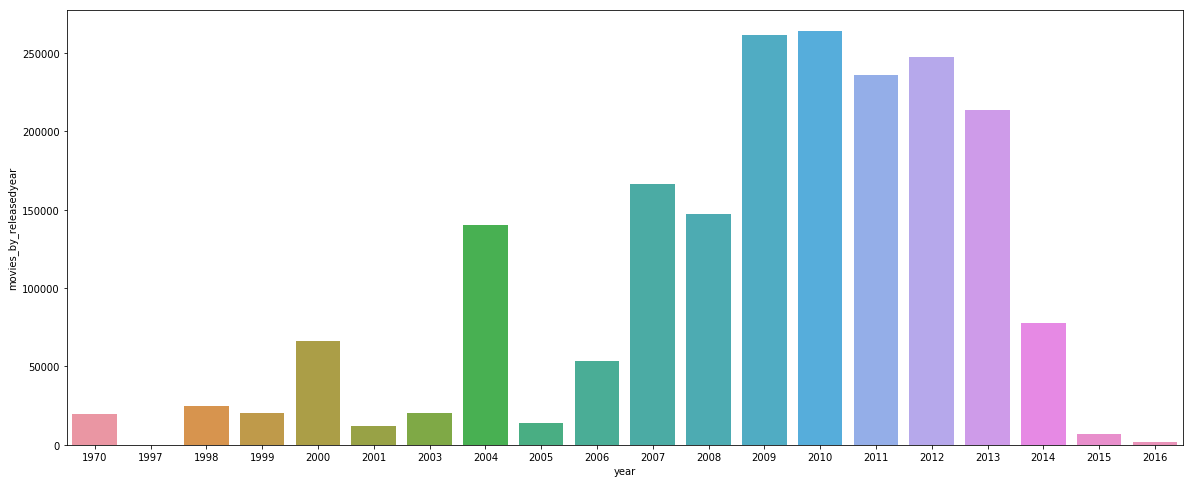

In [155]:
count_plot_year(year_game_cluster3)

__Cluster 4__

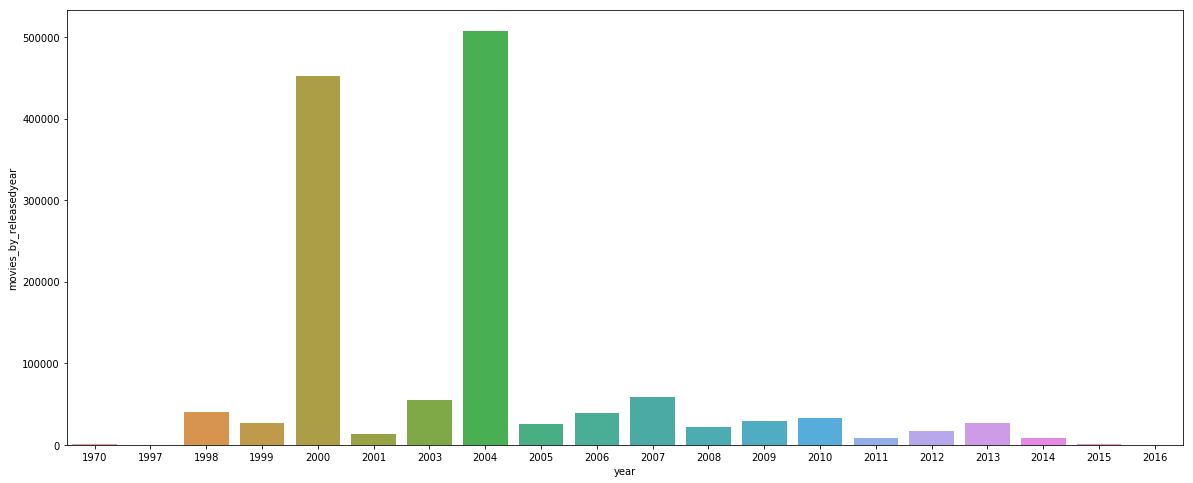

In [156]:
count_plot_year(year_game_cluster4)

__Cluster 5__

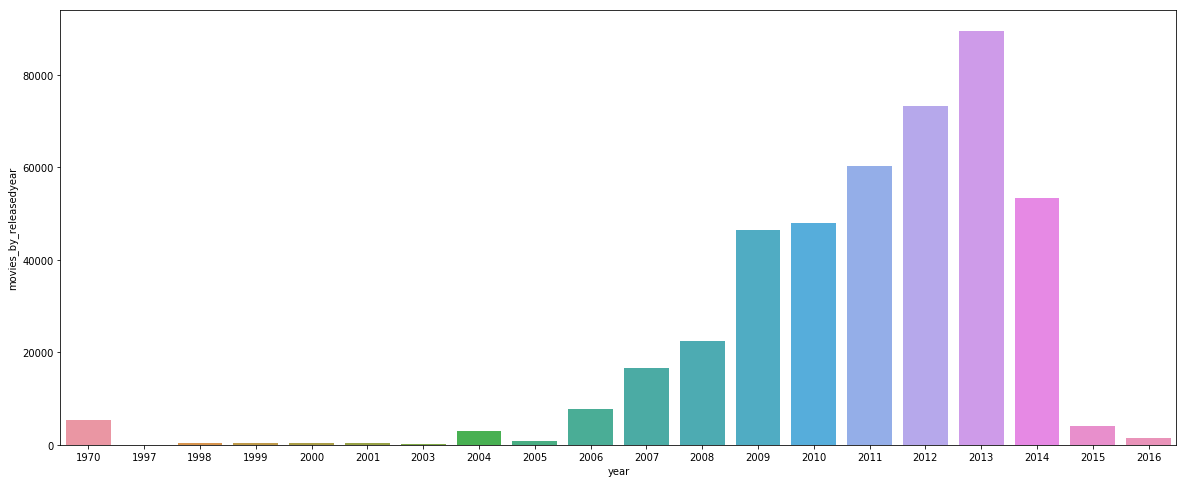

In [157]:
count_plot_year(year_game_cluster5)

_Country based_

In [76]:
player_final_cluster.filter(F.col('cluster')==0).groupby('country_code').count().orderBy('count', ascending = False).limit(15)

+------------+-----+
|country_code|count|
+------------+-----+
|           N|10942|
|          US|10298|
|          GB| 3136|
|          CA| 1569|
|          AU| 1412|
|          DE| 1302|
|          SE|  600|
|          FR|  492|
|          FI|  443|
|          DK|  403|
|          ES|  392|
|          NO|  362|
|          NL|  298|
|          JP|  227|
|          BR|  215|
|          BE|  212|
|          IT|  194|
|          AT|  165|
|          NZ|  163|
|          PL|  129|
+------------+-----+
only showing top 20 rows



In [77]:
player_final_cluster.filter(F.col('cluster')==5).groupby('country_code').count().orderBy('count', ascending = False).show()

+------------+-----+
|country_code|count|
+------------+-----+
|           N|  378|
|          US|  337|
|          GB|  135|
|          CA|   64|
|          DE|   61|
|          AU|   44|
|          SE|   28|
|          ES|   25|
|          JP|   22|
|          FR|   20|
|          IT|   18|
|          FI|   17|
|          NO|   16|
|          NL|   13|
|          AT|   10|
|          BE|   10|
|          RU|    9|
|          BR|    8|
|          NZ|    7|
|          DK|    7|
+------------+-----+
only showing top 20 rows



In [79]:
player_final_cluster.filter(F.col('cluster')==4).groupby('country_code').count().orderBy('count', ascending = False).show()

+------------+-------+
|country_code|  count|
+------------+-------+
|           N|1208571|
|          US|  20981|
|          DE|  11411|
|          FR|   7961|
|          GB|   4924|
|          SE|   4643|
|          CA|   4285|
|          BR|   2362|
|          AU|   2091|
|          BE|   1939|
|          PL|   1793|
|          ES|   1788|
|          DK|   1694|
|          NO|   1547|
|          KR|   1424|
|          NL|   1366|
|          FX|   1326|
|          FI|   1243|
|          TW|    908|
|          PT|    828|
+------------+-------+
only showing top 20 rows



---
### 4. Publisher and Developer

In [6]:
game_dgp = spark.read.csv('/user/tamng/jwht/CleanData/game_dgp.csv', inferSchema = True, header = True)

In [7]:
game_dgp.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- gamesDeveloper: string (nullable = true)
 |-- gamesGenre: string (nullable = true)
 |-- gamesPublisher: string (nullable = true)



In [46]:
basic_info(game_dgp)

TOTAL ROWS: 46404


*-------------*-------------*-------------*-------------*-------------


MISSING VALUE:
+------+--------------+----------+--------------+
|app_id|gamesDeveloper|gamesGenre|gamesPublisher|
+------+--------------+----------+--------------+
|     0|             0|       580|          6102|
+------+--------------+----------+--------------+

*-------------*-------------*-------------*-------------*-------------


PRINT OUT THE 1st 3 LINES:
+------+--------------+----------+--------------+
|app_id|gamesDeveloper|gamesGenre|gamesPublisher|
+------+--------------+----------+--------------+
|    10|         Valve|    Action|         Valve|
|    20|         Valve|    Action|         Valve|
|    30|         Valve|    Action|         Valve|
+------+--------------+----------+--------------+
only showing top 3 rows

*-------------*-------------*-------------*-------------*-------------


TABLE BASIC DESCRIPTION:
+-------+------------------+-----------------+--------------+-------

In [108]:
game_dgp.filter(F.col('gamesDeveloper')=='Valve').count()

51

In [18]:
game_dgp.groupby('gamesDeveloper').count().orderBy('count', ascending = False).limit(10).toPandas()

,gamesDeveloper,count
0,Ubisoft - San Francisco,1698
1,Feral Interactive (Mac),822
2,Feral Interactive (Linux),559
3,"SmiteWorks USA, LLC",480
4,Avalanche,314
5,Relic Entertainment,302
6,Dovetail Games,234
7,Crystal Dynamics,219
8,Gearbox Software,217
9,Paradox Development Studio,214


In [30]:
game_d = game_dgp.select('app_id', 'gamesDeveloper').dropDuplicates()
game_d.groupby('gamesDeveloper').count().orderBy('count', ascending = False).limit(10).toPandas()

,gamesDeveloper,count
0,Ubisoft - San Francisco,850
1,Dovetail Games,233
2,Feral Interactive (Mac),227
3,"SmiteWorks USA, LLC",185
4,Avalanche,158
5,Feral Interactive (Linux),148
6,Relic Entertainment,130
7,"KOEI TECMO GAMES CO., LTD.",120
8,Paradox Development Studio,112
9,Stainless Games,111


In [37]:
game_p = game_dgp.select('app_id', 'gamesPublisher').dropDuplicates()
game_p.groupby('gamesPublisher').count().orderBy('count', ascending = False).limit(11).toPandas()[1:]

,gamesPublisher,count
1,Ubisoft,376
2,SEGA,339
3,Dovetail Games - Trains,279
4,Paradox Interactive,247
5,Disney Interactive,227
6,Feral Interactive (Mac),221
7,Activision,218
8,Degica,190
9,Nordic Games,164
10,Square Enix,148


---
### Revenue by games, developer, genre
count distinct by app_id

In [25]:
player_app_cluster= spark.read.csv('/user/tamng/jwht/EDA/player_app_cluster.csv', inferSchema = True,header = True)

In [26]:
game_revenue = player_app_cluster.select('app_id','price').dropDuplicates().groupby('app_id').agg(F.sum('price').alias('total_revenue_game'))

In [27]:
game_revenue.limit(10).toPandas()

,app_id,total_revenue_game
0,9900,0.00
1,4900,4.99
2,265240,9.99
3,241660,0.00
4,205270,19.99
5,7340,9.99
6,304030,0.00
7,245390,5.99
8,212010,19.99
9,234080,29.99


In [31]:
game_d = game_d.join(game_revenue, 'app_id')
game_d.orderBy('total_revenue_game', ascending = False).limit(20).toPandas()

,app_id,gamesDeveloper,total_revenue_game
0,279280,Ohm Force,124.99
1,41060,Croteam,99.99
2,251810,Leadwerks Software,99.99
3,100980,Pilgway,99.99
4,41070,Croteam,99.99
5,248170,Clickteam,99.99
6,41050,Croteam,99.99
7,281900,Eldon Harris,99.99
8,230780,Byterockers' Games GmbH & Co. KG,99.99
9,241790,Cakewalk,99.99


In [34]:
game_d.groupby('gamesDeveloper').agg(F.sum('total_revenue_game').alias('revenue')).orderBy('revenue', ascending = False).limit(20).toPandas()

,gamesDeveloper,revenue
0,Telltale Games,542.69
1,Feral Interactive (Mac),538.76
2,Daedalic Entertainment,449.86
3,Croteam,394.92
4,Infinity Ward,299.91
5,MumboJumbo,287.71
6,Bohemia Interactive,262.84
7,Aspyr (Mac),259.88
8,Ubisoft Montreal,249.83
9,Valve,225.79


----

### Scraping data

Leave it there for now

In [78]:
# scraping data
scraping = spark.read.csv('/user/tamng/jwht/SteamData/Steam_Scraping.csv',inferSchema = True, header = True)

In [73]:
scraping = scraping.withColumn('release_date', \
                              (scraping.release_date).cast('timestamp'))

In [75]:
# Change format to timestamp
scraping = scraping.withColumn('YearReleased', \
                               year(F.col('release_date')))

In [76]:
scraping.printSchema()

root
 |-- game_url: string (nullable = true)
 |-- img_url: string (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- game_name: string (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- platforms: string (nullable = true)
 |-- reviews_summary: string (nullable = true)
 |-- original_price: string (nullable = true)
 |-- discount_rate: string (nullable = true)
 |-- discounted_price: string (nullable = true)
 |-- YearReleased: integer (nullable = true)



In [79]:
scraping.limit(5).toPandas()

,game_url,img_url,app_id,game_name,release_date,platforms,reviews_summary,original_price,discount_rate,discounted_price
0,https://store.steampowered.com/app/730/Counter...,https://steamcdn-a.akamaihd.net/steam/apps/730...,730,Counter-Strike: Global Offensive,21-Aug-12,"['Windows', 'Mac os', 'Linux']","Very Positive87% of the 4,285,604 user reviews...",Free to Play,None,None
1,https://store.steampowered.com/app/397540/Bord...,https://steamcdn-a.akamaihd.net/steam/apps/397...,397540,Borderlands 3,13-Mar-20,['Windows'],"Very Positive81% of the 26,362 user reviews fo...",$59.99,50%,$29.99
2,https://store.steampowered.com/app/582010/MONS...,https://steamcdn-a.akamaihd.net/steam/apps/582...,582010,MONSTER HUNTER: WORLD,9-Aug-18,['Windows'],"Very Positive82% of the 144,277 user reviews f...",$29.99,34%,$19.79
3,https://store.steampowered.com/app/306130/The_...,https://steamcdn-a.akamaihd.net/steam/apps/306...,306130,The Elder Scrolls® Online,22-May-17,"['Windows', 'Mac os']","Very Positive81% of the 58,008 user reviews fo...",$19.99,None,None
4,https://store.steampowered.com/app/359550/Tom_...,https://steamcdn-a.akamaihd.net/steam/apps/359...,359550,Tom Clancy's Rainbow Six® Siege,1-Dec-15,['Windows'],"Very Positive88% of the 552,650 user reviews f...",$19.99,None,None
